In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.file.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.datastructure import DataObject


from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.dpc import get_CoM_images, get_phase_from_CoM
from py4DSTEM.process.dpc import get_wavenumber, get_interaction_constant

from matplotlib.patches import Circle

In [22]:
fp3 = "C:/Users/Roberto/Desktop/data_enamel/enamel_combo_large_3p5mrad.h5"

In [23]:
dc3 = py4DSTEM.file.io.read(fp3)

C:/Users/Roberto/Desktop/data_enamel/enamel_combo_large_3p5mrad.h5 is a py4DSTEM file, v0.5. Reading...


In [24]:
DataObject.get_dataobjects()

In [25]:
DataObject.sort_dataobjects_by_type(show=True)

 Index                  Name                        Type        
   0    CBED_array_depth0000                DataCube            
   1    CBED_array_depth0000                DataCube            
   2    CBED_array_depth0000                DataCube            
   3    CBED_array_depth0000                DataCube            


In [26]:
ar3 = DataObject.get_dataobject_by_index(3)

In [16]:
# ar00.data.shape, ar02.data.shape,ar010.data.shape

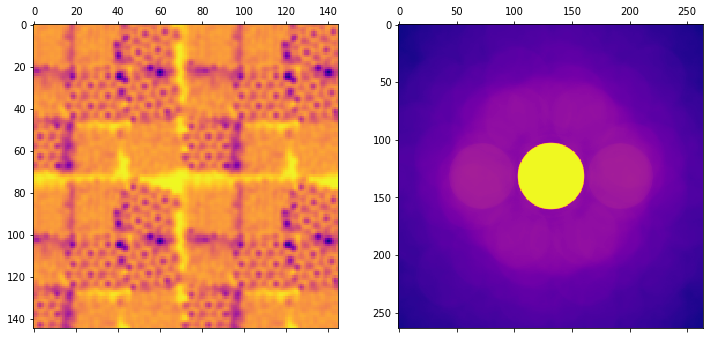

In [30]:
power = 0.02

BF3 = np.average(ar3.data,axis=(2,3))
aveDP3 = np.average(ar3.data,axis=(0,1))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF3, cmap="plasma")
ax2.matshow(np.log10(abs(aveDP3)), cmap="plasma")

plt.savefig("sim_3_5mrad.png")
plt.show()

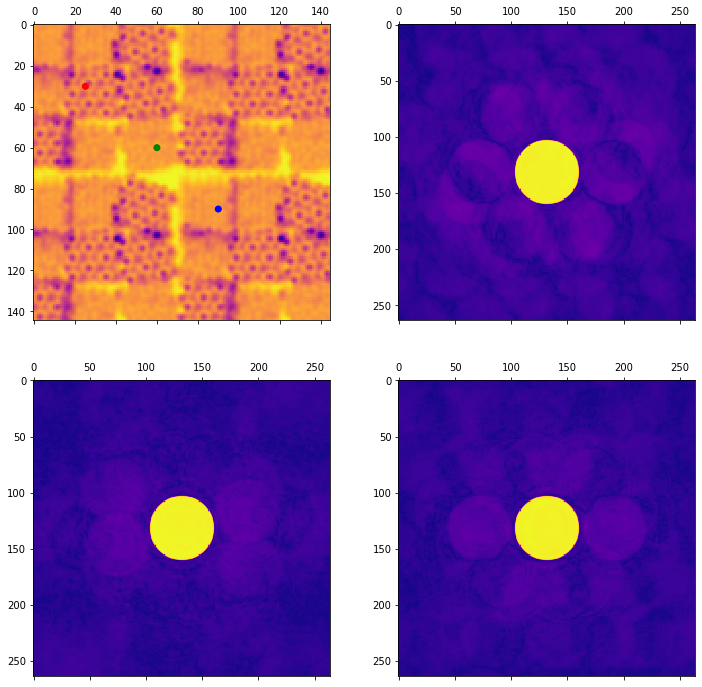

In [42]:
# Select scan positions
Rxs=(30,60,90)
Rys=(25,60,90)
power = 0.3

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(BF3, cmap="plasma")
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(ar3.data[Rxs[0],Rys[0],:,:]**power, cmap="plasma")
ax21.matshow(ar3.data[Rxs[1],Rys[1],:,:]**power, cmap="plasma")
ax22.matshow(ar3.data[Rxs[2],Rys[2],:,:]**power, cmap="plasma")

plt.savefig("sim_3_5mrad_combo.png")
plt.show()